## Statistics of Tropical Cyclones (TCs) wind fields derived from Synthetic Aperture Radar (SAR) imagery
Dataset of 341 SAR files stored in .zarr format


In [1]:
# General
import glob
import os.path
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import pandas as pd

# Data treatment
import dask as da
import zarr
import geopy.distance
from scipy.interpolate import griddata
from scipy.optimize import curve_fit
from datetime import datetime

# Reference methods for regression and maths
import pickle
import sklearn.linear_model
from sklearn import metrics
from sklearn import svm
from pygam import LinearGAM, s, l, f
from pygam.terms import TermList
import statsmodels.api as sm
from scipy import stats

# Custom
import dataUtils as du

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)

In [2]:
### TODO: Google Cloud data access and opening

### PATHS
dir_path = '/home/arthur/data/cyclobs/centered_rotated_files_06012022/clean_dataset/zarr_data/'
filename = 'tc_sar_data.zarr'


### OPEN FILES
ds_all = xr.open_zarr(dir_path + filename)

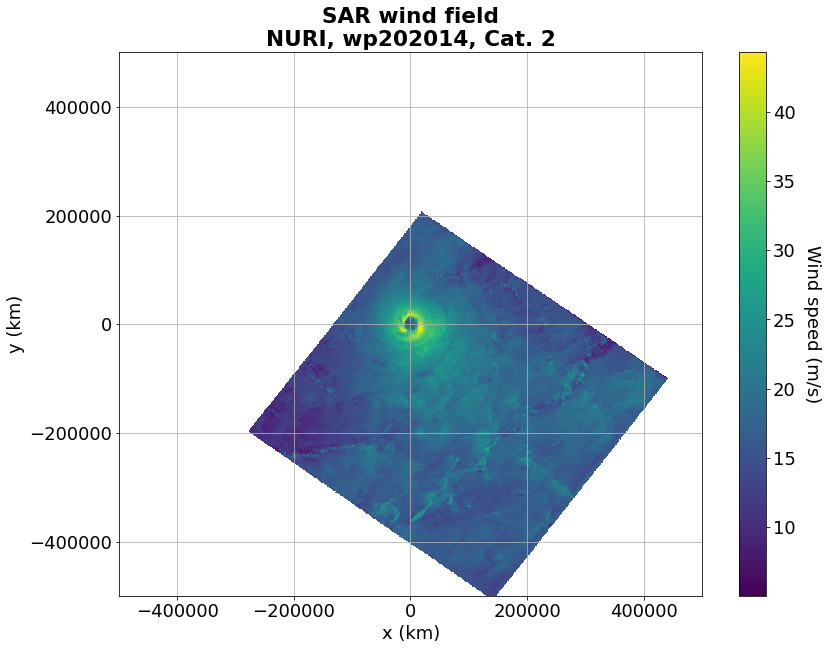

In [33]:
### PLOTTING WIND FIELDS
def plot_wind_field(ds_all, time_idx):
    # Open figure
    fig, _ = plt.subplots()
    
    # Title
    name = ds_all.isel(time=time_idx)['storm_name'].values
    tcId = ds_all.isel(time=time_idx)['storm_id'].values
    cat  = int(ds_all.isel(time=time_idx)['cat'])
    plt.title('SAR wind field\n%s, %s, Cat. %i'%(name, tcId, cat), weight='bold')
    
    # Plot
    x, y = np.meshgrid(ds_all.isel(time=time_idx)['x'], ds_all.isel(time=time_idx)['y']) # Defining 2D coordinates
    plt.pcolormesh(x, y, ds_all.isel(time=time_idx)['wind_speed'])                       # Plot the wind field
    plt.xlabel('x (km)');plt.ylabel('y (km)');plt.grid()                                 # Add axis legend
    plt.subplots_adjust(right=0.8)                                                       # Colorbar - line 1
    cbar = plt.colorbar()                                                                # Colorbar - line 2
    cbar.set_label('Wind speed (m/s)', rotation=270);cbar.ax.get_yaxis().labelpad=25     # Colorbar - line 3
    
plot_wind_field(ds_all, time_idx=20)

Indexes for HECTOR:  [  0  85  86  87 154 155 269 270]


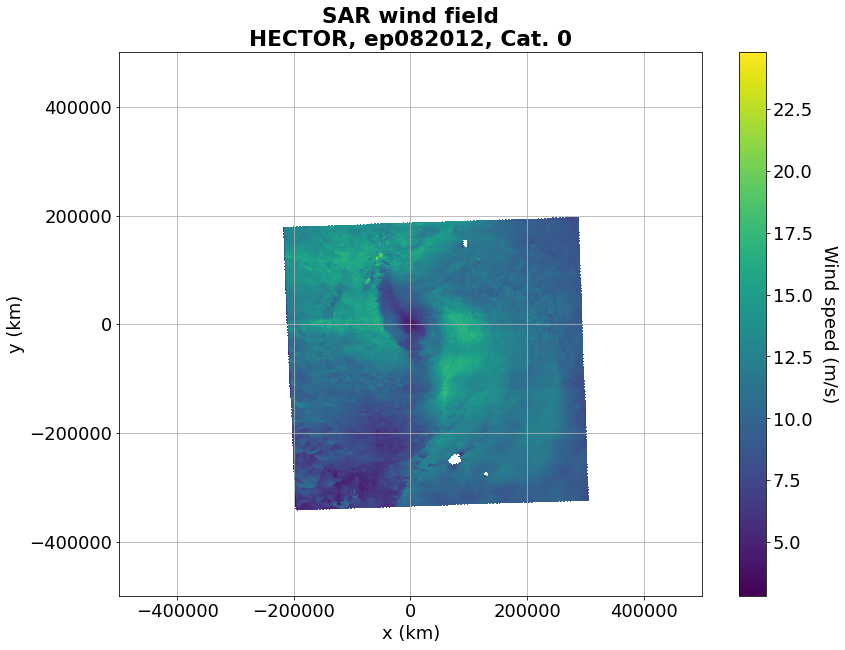

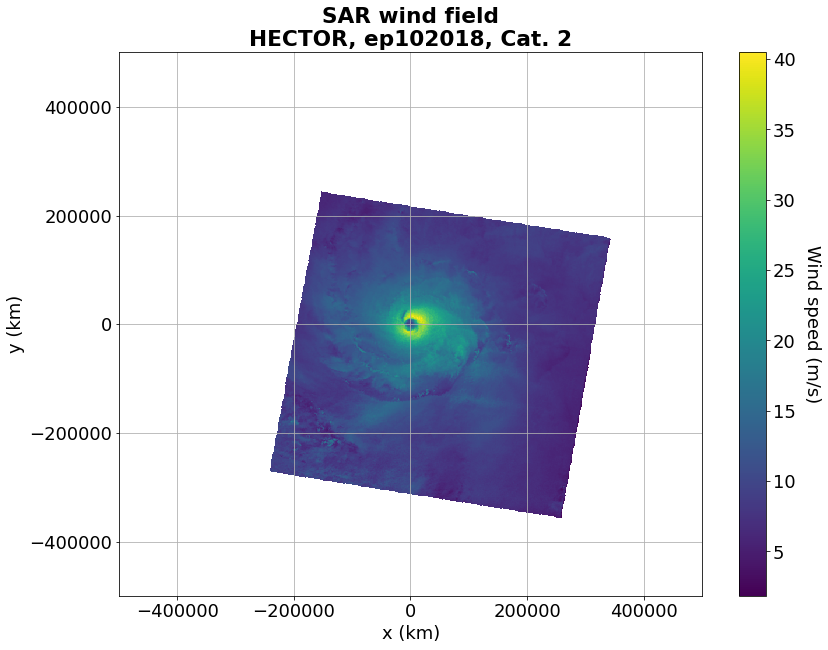

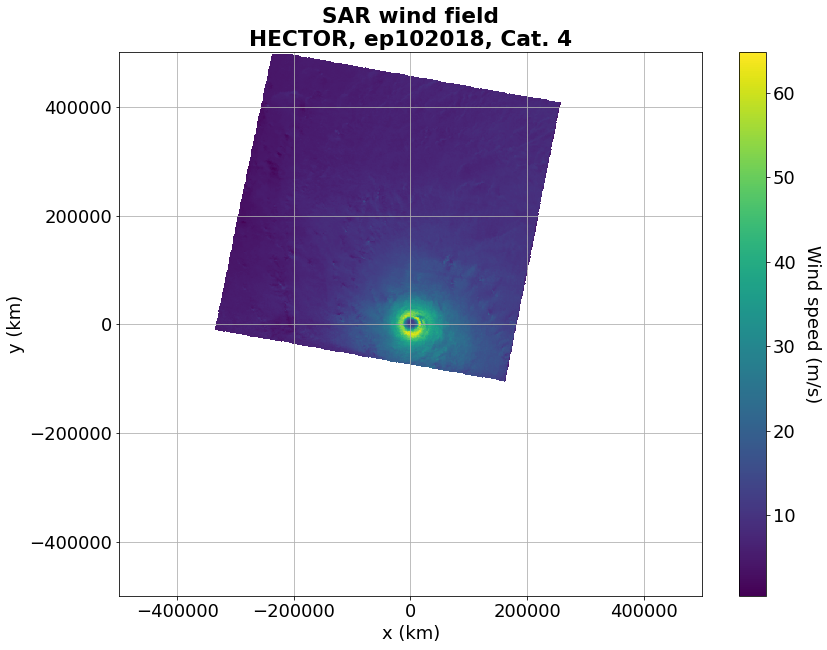

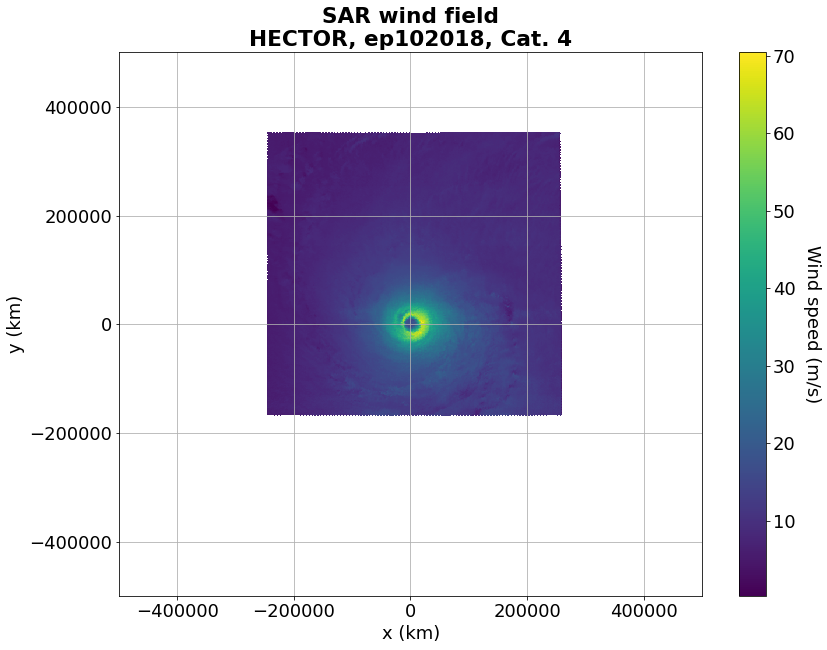

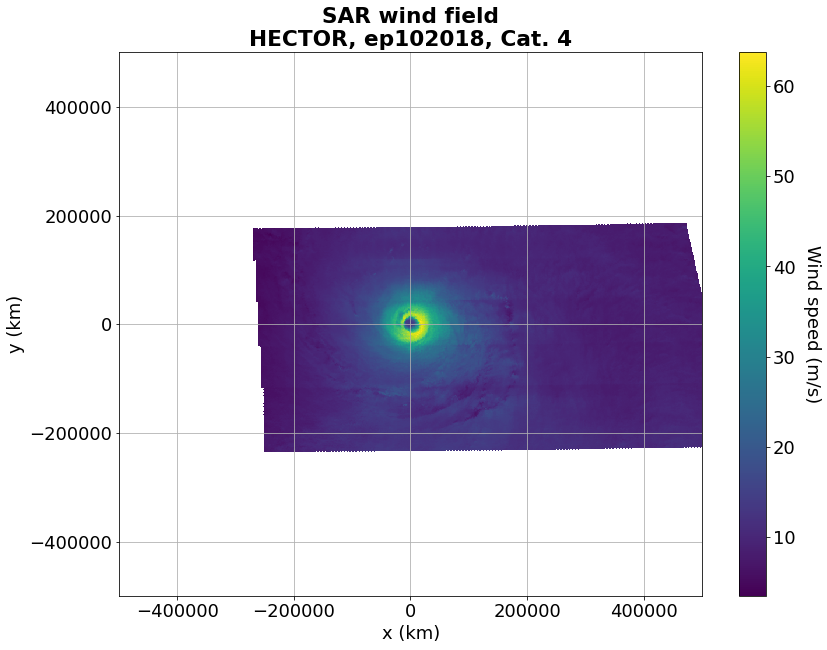

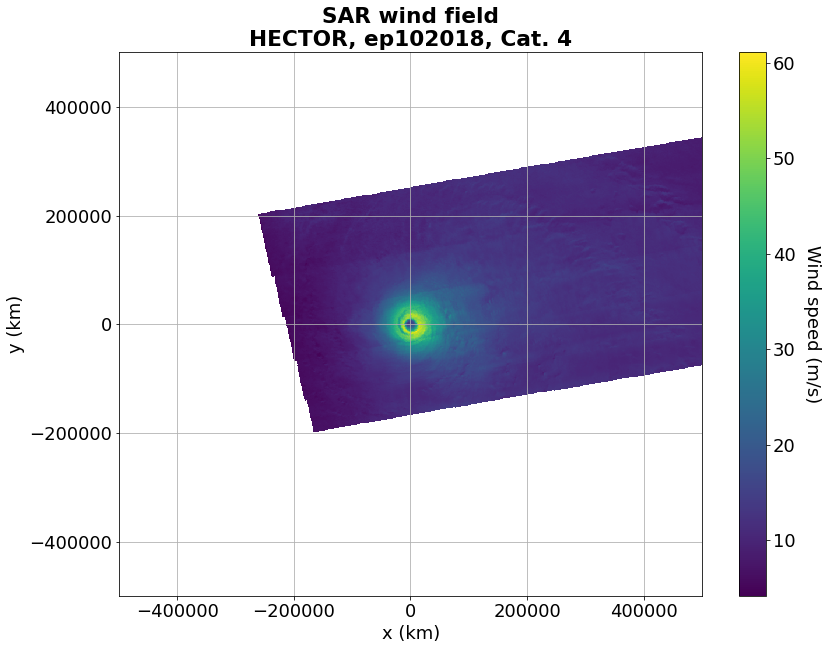

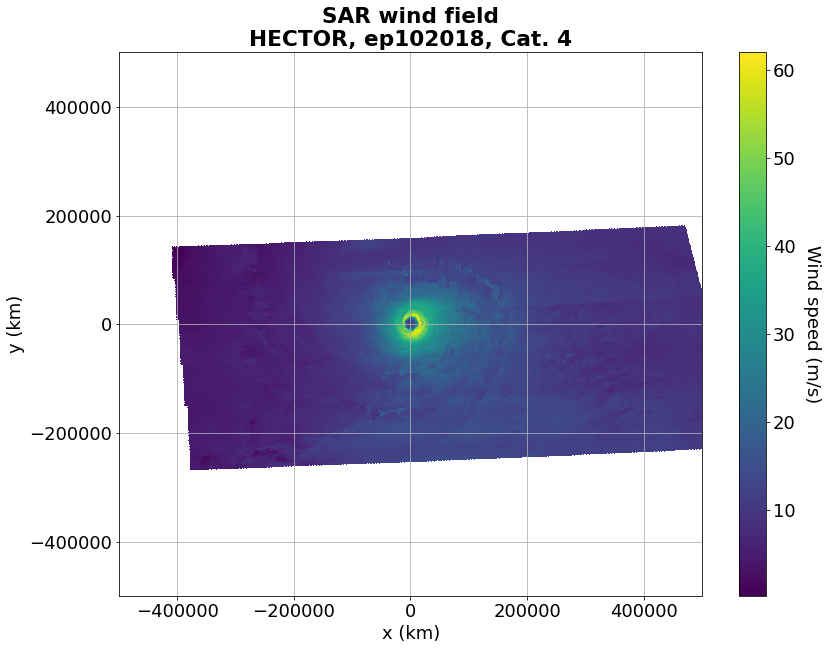

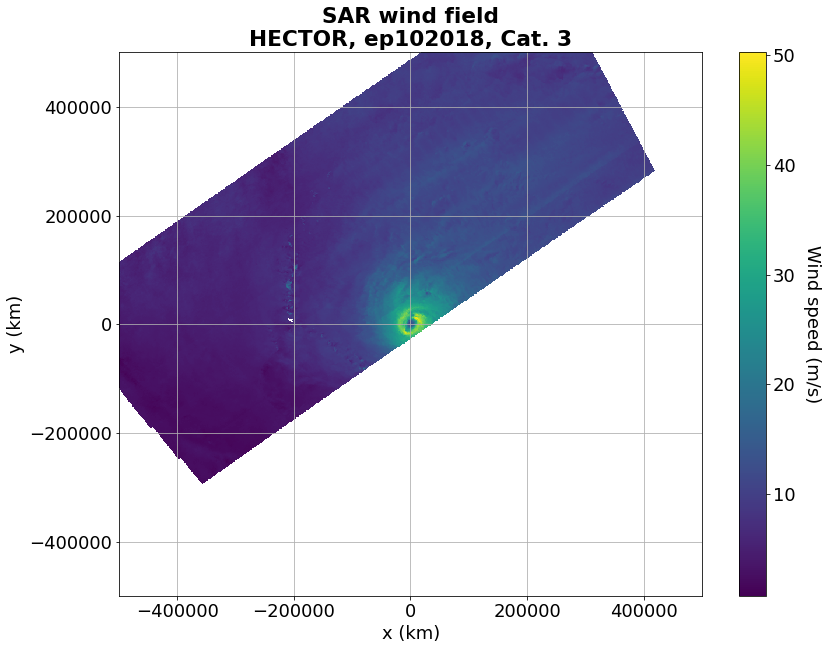

In [75]:
### FIND ALL TIME INDEXES FROM NAME AND PLOT ALL CORRESPONDING OBSERVATIONS
def find_time_idx(ds_all, storm_name):
    return np.where(ds_all['storm_name']==storm_name)[0]

storm_name = 'HECTOR'
print('Indexes for %s: '%storm_name, find_time_idx(ds_all, storm_name))
for time_idx in find_time_idx(ds_all, storm_name):
    plot_wind_field(ds_all, time_idx)

In [47]:
ds_all['storm_name'].where('storm_name'=='HECTOR').values

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [40]:
ds_all.where('storm_name'=='LARRY')

<xarray.Dataset>
Dimensions:                                        (time: 341, x: 1000, y: 1000)
Coordinates:
  * time                                           (time) datetime64[ns] 2012...
  * x                                              (x) int64 -499000 ... 500000
  * y                                              (y) int64 -499000 ... 500000
Data variables: (12/35)
    across_wind_from_direction_component           (time, x, y) float64 dask.array<chunksize=(341, 1000, 1000), meta=np.ndarray>
    across_wind_parametrized                       (time, x, y) float64 dask.array<chunksize=(341, 1000, 1000), meta=np.ndarray>
    across_wind_streaks_orientation_component      (time, x, y) float64 dask.array<chunksize=(341, 1000, 1000), meta=np.ndarray>
    along_wind_from_direction_component            (time, x, y) float64 dask.array<chunksize=(341, 1000, 1000), meta=np.ndarray>
    along_wind_parametrized                        (time, x, y) float64 dask.array<chunksize=(341, 1000, 1000), meta=np.ndarray>
    along_wind_streaks_orientation_component       (time, x, y) float64 dask.array<chunksize=(341, 1000, 1000), meta=np.ndarray>
    ...                                             ...
    tangential_wind_streaks_orientation_component  (time, x, y) float64 dask.array<chunksize=(341, 1000, 1000), meta=np.ndarray>
    wind_from_direction                            (time, x, y) float64 dask.array<chunksize=(341, 1000, 1000), meta=np.ndarray>
    wind_speed                                     (time, x, y) float64 dask.array<chunksize=(341, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation                       (time, x, y) float64 dask.array<chunksize=(341, 1000, 1000), meta=np.ndarray>
    wind_streaks_orientation_stddev                (time, x, y) float64 dask.array<chunksize=(341, 1000, 1000), meta=np.ndarray>
    zonal_interp_parametrized                      (time, x, y) float64 dask.array<chunksize=(341, 1000, 1000), meta=np.ndarray>

In [29]:
print('ok')

ok
